In [1]:
import warnings
warnings.filterwarnings('ignore')
# Setup
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [2]:
from scipy.io import loadmat
mnist_raw = loadmat("./mnist-original.mat")
mnist = {
    "data": mnist_raw["data"].T,
    "target": mnist_raw['label'][0],
    "COL_NAMES": ["label", "data"],
    "DESCR": "mldata.org dataset: mnist-original"
}

In [3]:
X, y = mnist['data'], mnist['target']
X.shape

(70000, 784)

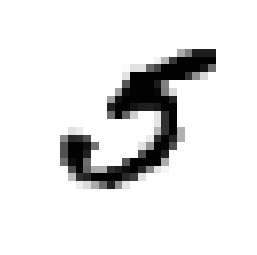

In [4]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000]
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image, cmap=matplotlib.cm.binary, interpolation='nearest')
plt.axis('off')
plt.show()

In [5]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

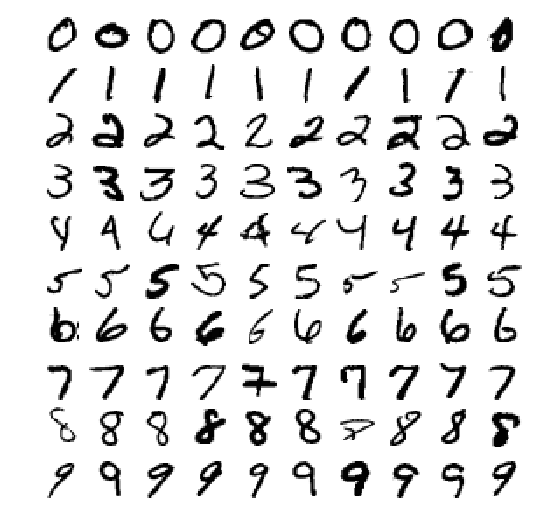

In [6]:
plt.figure(figsize=(9,9))
example_images = np.r_[X[:12000:600], X[13000:30600:600], X[30600:60000:590]]
plot_digits(example_images, images_per_row=10)
plt.show()

In [7]:
# Split training and test sets
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
# Shuffle data to ensure even number distribution across cross-validation folds
import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

In [8]:
# Train binary classifier to recognize if digit is 5 or not
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits
y_test_5 = (y_test == 5)

In [9]:
# Train stochastic gradient descent classifier on data
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [10]:
# Evaluate model using cross validation

from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.9502 , 0.96565, 0.96495])

In [11]:
# The above model seems to work, however accuracy is not generally the preferred performance measure because only
# 10% of the training data contains the digit 5. This means a model that guesses NOT 5 everytime will have 
# 90% accuracy
# A better way to evaluate is to look at the confusion matrix
# A confusion matrix counts the number of times instances of class A are classified as class B
# For example, the number of times a classifier confused images of 5s with 3s, you would look at the 5th row
# and 3rd column of the confusion matrix

# To compute, you need a set of predictions to be compared to the targets
# cross_val_predict() performs K-fold cross-validation, but returns predictions instead of evaluation scores
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

from sklearn.metrics import confusion_matrix

confusion = confusion_matrix(y_train_5, y_train_pred)

In [12]:
print(confusion)
# Each row contains a class and each column contains predictions
# A perfect confusion matrix would look like this:
# [[54579,    0]
#  [    0, 5421]] 

[[53272  1307]
 [ 1077  4344]]


In [13]:
# TP = true positives  FP = false positives
# TN = true negatives  FN = false negatives
# Precision = TP/(TP + FP)
# Recall = TP/(TP + FN)
from sklearn.metrics import precision_score, recall_score

print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))

0.7687135020350381
0.801328168234643


In [14]:
# F1 score combines precision and recall into one by taking the harmonic mean of both
# The harmonic mean puts more weight on high values, so F1 will only be high if both prec. and recall are high
# F1 = 2/((1/precision)+(1/recall)) = 2 * ((precision * recall)/(precision + recall))
# F1 = TP/(TP + ((FN + FP)/2))
from sklearn.metrics import f1_score

print(f1_score(y_train_5, y_train_pred))

0.7846820809248555


In [15]:
# Setting the decision threshold allows you to decide if you want your model to have high precision, or
# high recall. (Higher threshold means higher precision, lower threshold means higher recall)
# Scikit learn does not let you do this directly, but you can call its decision_function() method , which
# returns a score for each instance. You can use this to make predictions for any threshold you want
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)
threshold = 20000
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[161855.74572176]
[ True]


In [16]:
# How do you decide what threshold to use? In order to do this, you must first get decision scores for all 
# instances in the training set
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')
# With these scores, you can compute precision and recall for all possible thresholds using precision_recall_curve()
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [17]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.xlabel('Threshold')
    plt.legend(loc='upper left')
    plt.ylim([0,1])

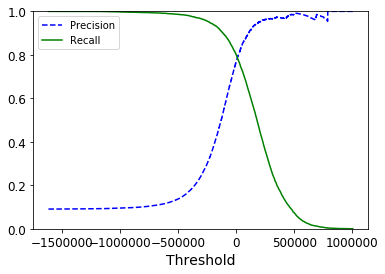

In [18]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()
# Now you simply select the threshold that gives you the best precision/recall tradeoff for your
# desired task (Some tasks are better suited for more recall and visa versa)

In [19]:
# Say you aim for about 90% precision, so you zoom in and pick a threshold at about 100,000
# To make predictions, instead of calling classifier's predict function, you do the following:
y_train_pred_90 = (y_scores > 100000)
print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

0.8935031847133758
0.646928610957388


In [20]:
# However, a high precision model is not useful if the recall us too low.
# The receiver operating characteristics (ROC) curve plots true positive rate (recall) vs false positive rate (FPR).
# FPR is the ratio of negative instances that are incorrectly classified as positive (equal to 1 - true negative rate).
# TNR is called specificity, therefore ROC curve plots sensitivity (recall) vs 1 - specificity
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [21]:
def plot_roc_curve(fpr,tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

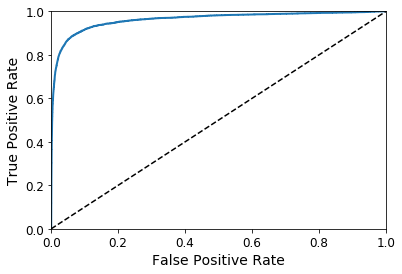

In [22]:
plot_roc_curve(fpr, tpr)
plt.show()
# Straight dashed line shows the ROC curve of a truly random classifier. A good classifier stays as far away
# from that line as possible (toward top left corner)

In [23]:
# One way to compare classifiers is to compare the area under the ROC curve (AUC)
# A perfect classifer will have an AUC equal to 1, while a purely random classifier will be equal to 0.5
from sklearn.metrics import roc_auc_score

print(roc_auc_score(y_train_5, y_scores))

0.9624496555967155


In [24]:
# Since ROC curve is so similar to precision/recall (PR) curve, you should prefer the PR curve whenever
# the positive class is rare or when you care more about false positives than false negatives, and the ROC otherwise
# Since there are so few positives (5s) compared to negatives (non 5s), the ROC curve makes the model appear very
# good, however the PR curve reveals the model has room for improvement (curve could be closer to the top right corner)
# Let's train a RandomForestClassifier and compare the ROC curve and ROC AUC
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

In [25]:
# But to plot a ROC curve, you need scores, not probabilities. A simple solution is to use the positive class's
# probability as the score
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

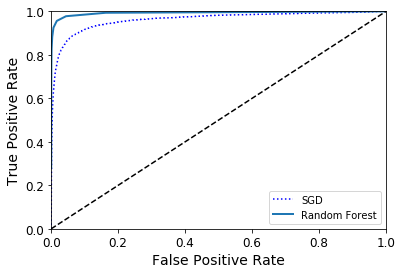

In [26]:
plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc='lower right')
plt.show()

In [27]:
print(roc_auc_score(y_train_5, y_scores_forest))

0.9931243366003829


In [28]:
# Some classifiers like Random Forest of naive Bayes are capable of handling multiple classes directly.
# However others like SVMs or linear classifiers are strictly binary classifiers
# You can perform multiclass classification using binary classifiers in two ways: OvA and OvO
# One-vs-All (OvA): Train 10 classifiers, one for each digit. Then classify image by selecting the classifier that
# outputs the highest score
# One-vs-One (OvO): Train a binary classifier for every pair of digits. One to distinguish 0s and 1s, another for 
# 0s and 2s, one for 1s and 2s, and so on. If there are N classes, you need to train N * (N-1)/2 classifers.
# For MNIST, that means training 45 classifiers. When classifying image, run image through all classifiers and 
# pick the one that won the most duels

# Scikit-Learn detects when you use a binary classification algorithm for a multi-class classification task, and
# it automatically runs OvA (except for SVMs, which uses OvO)
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([5.])

In [29]:
some_digit_scores = sgd_clf.decision_function([some_digit])
print(sgd_clf.classes_)
print(some_digit_scores)
print(np.argmax(some_digit_scores))
# You can see the highest score is the one that corresponds to the 5 class

[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
[[-311402.62954431 -363517.28355739 -446449.5306454  -183226.61023518
  -414337.15339485  161855.74572176 -452576.39616343 -471957.14962573
  -518542.33997148 -536774.63961222]]
5


In [30]:
# If you want SciKit Learn to use OvO or OvA, use OneVsOneClassifier or OneVsRestClassifier classes. Create
# an instance and pass a binary classifier to its constructor.
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
print(ovo_clf.predict([some_digit]))
print(len(ovo_clf.estimators_))

[5.]
45


In [31]:
# Training a random forest is even easier
forest_clf.fit(X_train, y_train)
print(forest_clf.predict([some_digit]))
print(forest_clf.predict_proba([some_digit]))
# Sklearn does not need to run OvO or OvA because Random Forest Classifiers can directly classify instances into
# multiple classes

[5.]
[[0.1 0.  0.  0.1 0.  0.8 0.  0.  0.  0. ]]


In [32]:
# Let's evaluate the SGD model
print(cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy'))

[0.84063187 0.84899245 0.86652998]


In [33]:
# We have above 83% accuracy on all folds. This is pretty good since a random classifier would be correct 10% of
# the time. We can do better, though
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.91011798, 0.90874544, 0.906636  ])

In [34]:
# Error Analysis

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
print(conf_mx)

[[5725    3   24    9   10   49   50   10   39    4]
 [   2 6493   43   25    7   40    5   10  109    8]
 [  51   41 5321  104   89   26   87   60  166   13]
 [  47   46  141 5342    1  231   40   50  141   92]
 [  19   29   41   10 5366    9   56   37   86  189]
 [  73   45   36  193   64 4582  111   30  193   94]
 [  29   34   44    2   42   85 5627   10   45    0]
 [  25   24   74   32   54   12    6 5787   15  236]
 [  52  161   73  156   10  163   61   25 5027  123]
 [  43   35   26   92  178   28    2  223   82 5240]]


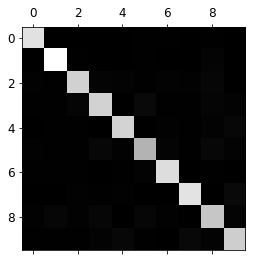

In [35]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

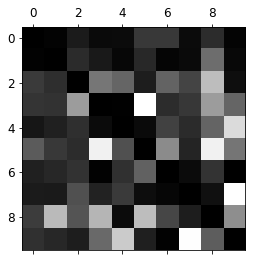

In [36]:
# The confusion matrix looks good, since most images are on the main diagonal, which means they were classified
# correctly, however if we focus the plot on the errors we will get more information
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
# Now let's fill the diagonal with zeros to keep only the errors and plot the result
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

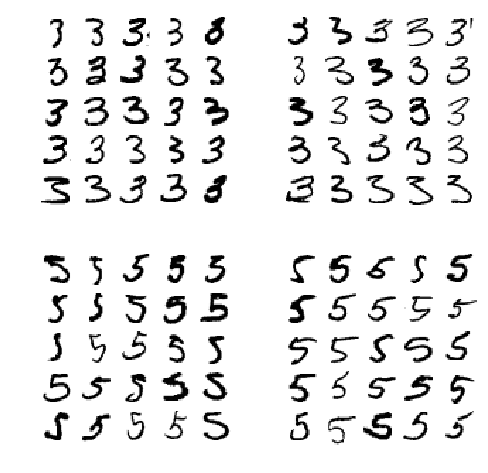

In [37]:
# Remember: rows represent actual classes, while columns represent predicted classes
# The matrix shows us that 3s are often confused with 5s, and 9s are often thought to be 7s
# Analyzing individual errors can be a good way to gain insight into what your classifier is doing and why it is
# failing, but it is more difficult and time-consuming. For example, let's plot examples of 3s and 5s
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221)
plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222)
plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223)
plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224)
plot_digits(X_bb[:25], images_per_row=5)
plt.show()
# Bottom left and top right blocks contain mislabeled examples

In [38]:
# Multilabel Classification
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]
# This creates an array containing 2 target labels for each digit image: whether or not the digit is large and
# whether or not it is odd
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)
# This creates a KNeighborsClassifier which supports multilabel classification, but not all classifiers do. Now
# you can make a prediction and get 2 output labels
print(knn_clf.predict([some_digit]))

[[False  True]]


In [ ]:
# There are many ways to evaluate a multilabel classifier, and selecting the right metric depends on the classifier
# One approach is to measure the F1 score for each individual label, then compute the average score
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_train, cv=3)
print(f1_score(y_train, y_train_knn_pred, average='macro'))

In [ ]:
# Multioutput classification
# Build a system that removes noise from images. It will input a noisy digit image and will output a clean digit image
# Start by creating the training and test sets by taking the MNIST images and adding noise to their pixel intensities
# using numpy's randint() function. The target images will be the original images
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [ ]:
# Training image
some_digit = X_train_mod[36003]
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image, cmap=matplotlib.cm.binary, interpolation='nearest')
plt.axis('off')
plt.show()

In [ ]:
# Equivalent target image
some_digit = X_train[36003]
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image, cmap=matplotlib.cm.binary, interpolation='nearest')
plt.axis('off')
plt.show()

In [ ]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_train_mod[36003]])
plot_digit(clean_digit)

In [ ]:
import tensorflow as tf

feature_columns = tf.contrib.learn.infer_real_valued_columns_from_input(X_train)
dnn_clf = tf.contrib.learn.DNNClassifier(hidden_units=[300, 100], n_classes=10,
                                        feature_columns=feature_columns)
new_y_train = y_train.astype(int)
dnn_clf.fit(x=X_train, y=new_y_train, batch_size=50, steps=40000)

In [ ]:
from sklearn.metrics import accuracy_score
y_pred = list(dnn_clf.predict(X_test))
accuracy_score(y_test, y_pred)

In [ ]:
X_train.shape

In [ ]:
# Training a DNN using plain TensorFlow
import tensorflow as tf

In [ ]:
n_inputs = 28*28
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name='X') # We don't yet know how large each batch will be
y = tf.placeholder(tf.int64, shape=(None), name='y')

In [ ]:
def neuron_layer(X, n_neurons, name, activation=None):
    with tf.name_scope(name):
        n_inputs = int(X.get_shape()[1])
        stddev = 2 / np.sqrt(n_inputs)
        init = tf.truncated_normal((n_inputs, n_neurons), stddev=stddev)
        W = tf.Variable(init, name="weights")
        b = tf.Variable(tf.zeros([n_neurons]), name='biases')
        z = tf.matmul(X, W) + b
        if activation == 'relu':
            return tf.nn.relu(z)
        else:
            return z

In [ ]:
# We can use this layer function to create our neural network
with tf.name_scope('dnn'):
    hidden1 = neuron_layer(X, n_hidden1, 'hidden1', activation='relu')
    hidden2 = neuron_layer(hidden1, n_hidden2, 'hidden2', activation='relu')
    logits = neuron_layer(hidden2, n_outputs, 'outputs')

In [ ]:
# However tensorflow has a much easier way of doing this, using the fully_connected() function
from tensorflow.contrib.layers import fully_connected

with tf.name_scope('dnn'):
    hidden1 = fully_connected(X, n_hidden1, scope='hidden1')
    hidden2 = fully_connected(hidden1, n_hidden2, scope='hidden2')
    logits = fully_connected(hidden2, n_outputs, scope='outputs', activation_fn=None)

In [ ]:
# Now that we have the neural net all ready to go, we need to define the cost function
with tf.name_scope('loss'):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name='loss')
# softmax_cross_entropy_with_logits can handle one-hot encoding, while sparse_softmax_cross_entropy_with_loss handles
# ints from 0 to the number of classes-1

In [ ]:
learning_rate = 0.01

with tf.name_scope('train'):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [ ]:
with tf.name_scope('eval'):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [ ]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()